In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances_argmin_min


In [3]:

# Carregar os dados
dados = pd.read_csv("quake.csv")
dados.columns = ['Latitude', 'Longitude']

X = dados[['Latitude', 'Longitude']].values

# Escalonamento dos dados
escalonador = StandardScaler()
X_escalonado = escalonador.fit_transform(X)


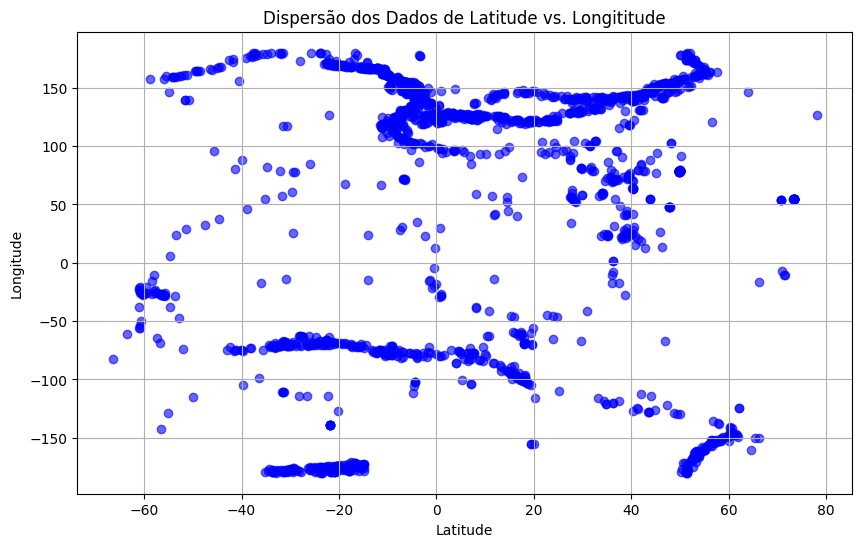

In [4]:

# Plotar o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(dados['Latitude'], dados['Longitude'], color='blue', alpha=0.6)

# Configurações do gráfico
plt.title('Dispersão dos Dados de Latitude vs. Longititude')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.grid(True)
plt.show()

In [5]:
# Função para calcular a distância Euclidiana entre dois pontos
def calcular_distancia_euclidiana(ponto1, ponto2):
    return np.sqrt(np.sum((ponto1 - ponto2) ** 2))

# Função para inicializar os centroides com K-means++
def inicializar_centroides_kmeans_plus(dados, k):
    centroides = [dados[random.randint(0, dados.shape[0] - 1)]]
    for _ in range(1, k):
        distancias = np.array([min([calcular_distancia_euclidiana(ponto, centroide) for centroide in centroides]) for ponto in dados])
        probabilidade = distancias / distancias.sum()
        novo_centroide = dados[np.random.choice(range(dados.shape[0]), p=probabilidade)]
        centroides.append(novo_centroide)
    return np.array(centroides)

# Função para atribuir pontos aos grupos com base na distância aos centroides
def atribuir_grupos(dados, centroides):
    distancias = np.linalg.norm(dados[:, np.newaxis] - centroides, axis=2)
    grupos = np.argmin(distancias, axis=1)
    grupos_dict = {i: dados[grupos == i] for i in range(len(centroides))}
    return grupos_dict, grupos

# Função para atualizar os centroides com base nos grupos
def atualizar_centroides(grupos):
    novos_centroides = []
    for chave in grupos:
        if len(grupos[chave]) > 0:  # Verifica se o grupo não está vazio
            novo_centroide = np.mean(grupos[chave], axis=0)  # Calcula a média dos pontos no grupo
            novos_centroides.append(novo_centroide)
    return np.array(novos_centroides)

# Função K-médias
def kmeans(dados, k, maximo_iteracoes=100):
    centroides = inicializar_centroides_kmeans_plus(dados, k)
    for _ in range(maximo_iteracoes):
        grupos, grupos_ids = atribuir_grupos(dados, centroides)
        novos_centroides = atualizar_centroides(grupos)
        if np.allclose(centroides, novos_centroides):  # Se os centroides não mudarem
            break
        centroides = novos_centroides
    return grupos, centroides, grupos_ids


In [6]:

# Função para calcular a dispersão dentro do grupo
def calcular_dispersao(grupo, centroide):
    distancias = np.linalg.norm(grupo - centroide, axis=1)
    return np.mean(distancias)

# Função para calcular o índice Davies-Bouldin
def calcular_indice_davies_bouldin(grupos, centroides):
    num_grupos = len(centroides)
    dispersoes = [calcular_dispersao(grupos[i], centroides[i]) for i in range(num_grupos)]
    
    R = []
    for i in range(num_grupos):
        #índice de similaridade
        max_Rij = 0
        for j in range(num_grupos):
            if i != j:
                Dij = calcular_distancia_euclidiana(centroides[i], centroides[j])
                Rij = (dispersoes[i] + dispersoes[j]) / Dij
                max_Rij = max(max_Rij, Rij)
        R.append(max_Rij)
    
    indice_DB = np.mean(R)
    return indice_DB


In [7]:

# Avaliar o melhor valor de k
valores_k = range(4, 21)
melhor_indice_db = float('inf')
melhor_k = None
melhores_grupos = None
melhores_centroides = None

for k in valores_k:
    print(f'Iniciando k={k}')
    indice_db_minimo = float('inf')
    for _ in range(21):  # Repetir 20 vezes para obter a melhor solução
        grupos, centroides, grupos_ids = kmeans(X_escalonado, k)
        indice_db = calcular_indice_davies_bouldin(grupos, centroides)
        if indice_db < indice_db_minimo:
            indice_db_minimo = indice_db
            if indice_db_minimo < melhor_indice_db:
                melhor_indice_db = indice_db_minimo
                melhor_k = k
                melhores_grupos = grupos
                melhores_centroides = centroides
    print(f'k={k} completado com índice Davies-Bouldin: {indice_db_minimo}')



Iniciando k=4
k=4 completado com índice Davies-Bouldin: 0.5965965554831503
Iniciando k=5
k=5 completado com índice Davies-Bouldin: 0.6185432662171217
Iniciando k=6
k=6 completado com índice Davies-Bouldin: 0.5564378731908873
Iniciando k=7
k=7 completado com índice Davies-Bouldin: 0.6339889605141263
Iniciando k=8
k=8 completado com índice Davies-Bouldin: 0.5928082337830916
Iniciando k=9
k=9 completado com índice Davies-Bouldin: 0.6267048449341032
Iniciando k=10
k=10 completado com índice Davies-Bouldin: 0.5897978891911212
Iniciando k=11
k=11 completado com índice Davies-Bouldin: 0.5640245582200433
Iniciando k=12
k=12 completado com índice Davies-Bouldin: 0.5751450725926147
Iniciando k=13
k=13 completado com índice Davies-Bouldin: 0.5848440199643508
Iniciando k=14
k=14 completado com índice Davies-Bouldin: 0.5887419370763947
Iniciando k=15
k=15 completado com índice Davies-Bouldin: 0.5926204504324095
Iniciando k=16
k=16 completado com índice Davies-Bouldin: 0.5918158201696712
Iniciando k

O melhor valor de k é 6 com índice Davies-Bouldin de 0.5564378731908873


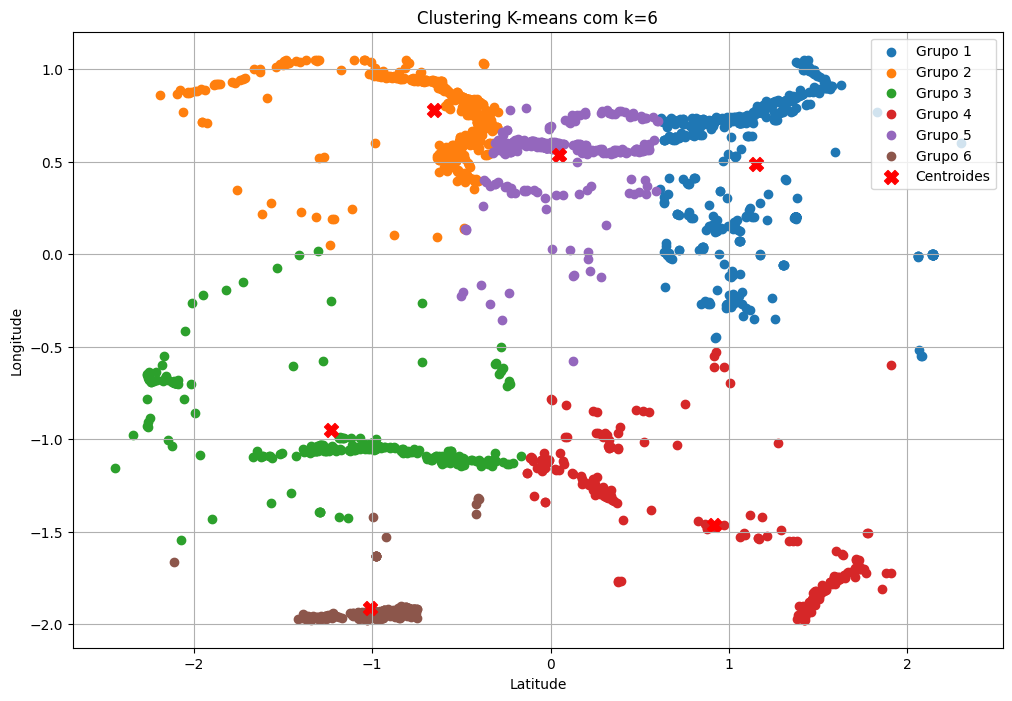

In [8]:
print(f'O melhor valor de k é {melhor_k} com índice Davies-Bouldin de {melhor_indice_db}')

# Plotar o melhor resultado de agrupamento
def plotar_resultado(X, grupos, centroides, k):
    plt.figure(figsize=(12, 8))
    for i in range(k):
        plt.scatter(X[grupos == i, 0], X[grupos == i, 1], label=f'Grupo {i+1}')
    
    plt.scatter(centroides[:, 0], centroides[:, 1], c='red', marker='X', s=100, label='Centroides')
    
    # Configurações do gráfico
    plt.title(f'Clustering K-means com k={k}')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotar o melhor resultado de agrupamento obtido
grupos, centroides, grupos_ids = kmeans(X_escalonado, melhor_k)
plotar_resultado(X_escalonado, grupos_ids, centroides, melhor_k)
